## Setup

In [1]:
import pandas as pd
import numpy as np
import math
import sklearn
from IPython.display import display, HTML, Image, SVG
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
print("pandas version: {} numpy version: {} sklearn version: {}".format(pd.__version__, 
                                                                        np.__version__, sklearn.__version__))

pandas version: 0.23.4 numpy version: 1.16.2 sklearn version: 0.20.3


In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def display_dataframe(df_in):
    s = df_in.style.set_properties(**{'text-align': 'left'})
    s.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    display(HTML(s.render()))

## Load Station Information

In [4]:
import urllib, json
url = 'https://cocorahsai.blob.core.windows.net/notes/station.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())
station_list_df = pd.DataFrame.from_dict(data)
len(station_list_df)

73704

### Create `StateCode - State` map

In [6]:
temp = station_list_df[['StateCode', 'State']].values
state_map = dict({tuple(row) for row in temp})

### Create County FIPS codes

In [7]:
station_list_df['county_fips'] = station_list_df[['StateCode', 'CountyCode']].apply(
    lambda x: format(x.StateCode, '02d') + format(x.CountyCode, '03d'), axis =1)

## Load Condition Monitoring Report

In [8]:
import urllib, json
url = 'https://cocorahsai.blob.core.windows.net/notes/condition_monitor_full.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())
df_c = pd.DataFrame.from_dict(data)
df_c = df_c[np.isfinite(df_c['ScaleBar'])]
len(df_c)

42013

### Join Condition Monitoring and Station information

In [9]:
merged_df = pd.merge(df_c, station_list_df, how='inner', left_on = 'StationID', 
                  right_on = 'StationID')
len(merged_df)

42013

## Monthly Box-and-Whisker Plot for the State of Colorado

### Create time attributes

In [10]:
cols = ['County', 'county_fips', 'City', 'StateCode', 'State', 'StationID', 'ConditionMonitoringReportID', 
        'ReportDate', 'ScaleBar', 'Description']

paried_df = merged_df[cols]

paried_df.ReportDate = pd.to_datetime(paried_df.ReportDate)
paried_df['year'] = paried_df['ReportDate'].apply(lambda x: x.year)
paried_df['quarter'] = paried_df['ReportDate'].apply(lambda x: x.quarter)
paried_df['month'] = paried_df['ReportDate'].apply(lambda x: x.month)
paried_df['month_name'] = paried_df['ReportDate'].apply(lambda x: x.strftime("%b"))
paried_df['week'] = paried_df['ReportDate'].apply(lambda x: x.week)
paried_df['day'] = paried_df['ReportDate'].apply(lambda x: x.day)

**Breakdown by year and filter by state = Colorado**

In [12]:
t_df_1 = paried_df.where((paried_df.year == 2017) & (paried_df.StateCode == 8)).dropna()
t_df_2 = paried_df.where((paried_df.year == 2018) & (paried_df.StateCode == 8)).dropna()
t_df_3 = paried_df.where((paried_df.year == 2019) & (paried_df.StateCode == 8)).dropna()

t_df_1.sort_values(by=['year', 'month'], ascending=True, inplace=True)
t_df_2.sort_values(by=['year', 'month'], ascending=True, inplace=True)
t_df_3.sort_values(by=['year', 'month'], ascending=True, inplace=True)

**Generate the Box-and-Whisker plot**

<IPython.core.display.Javascript object>


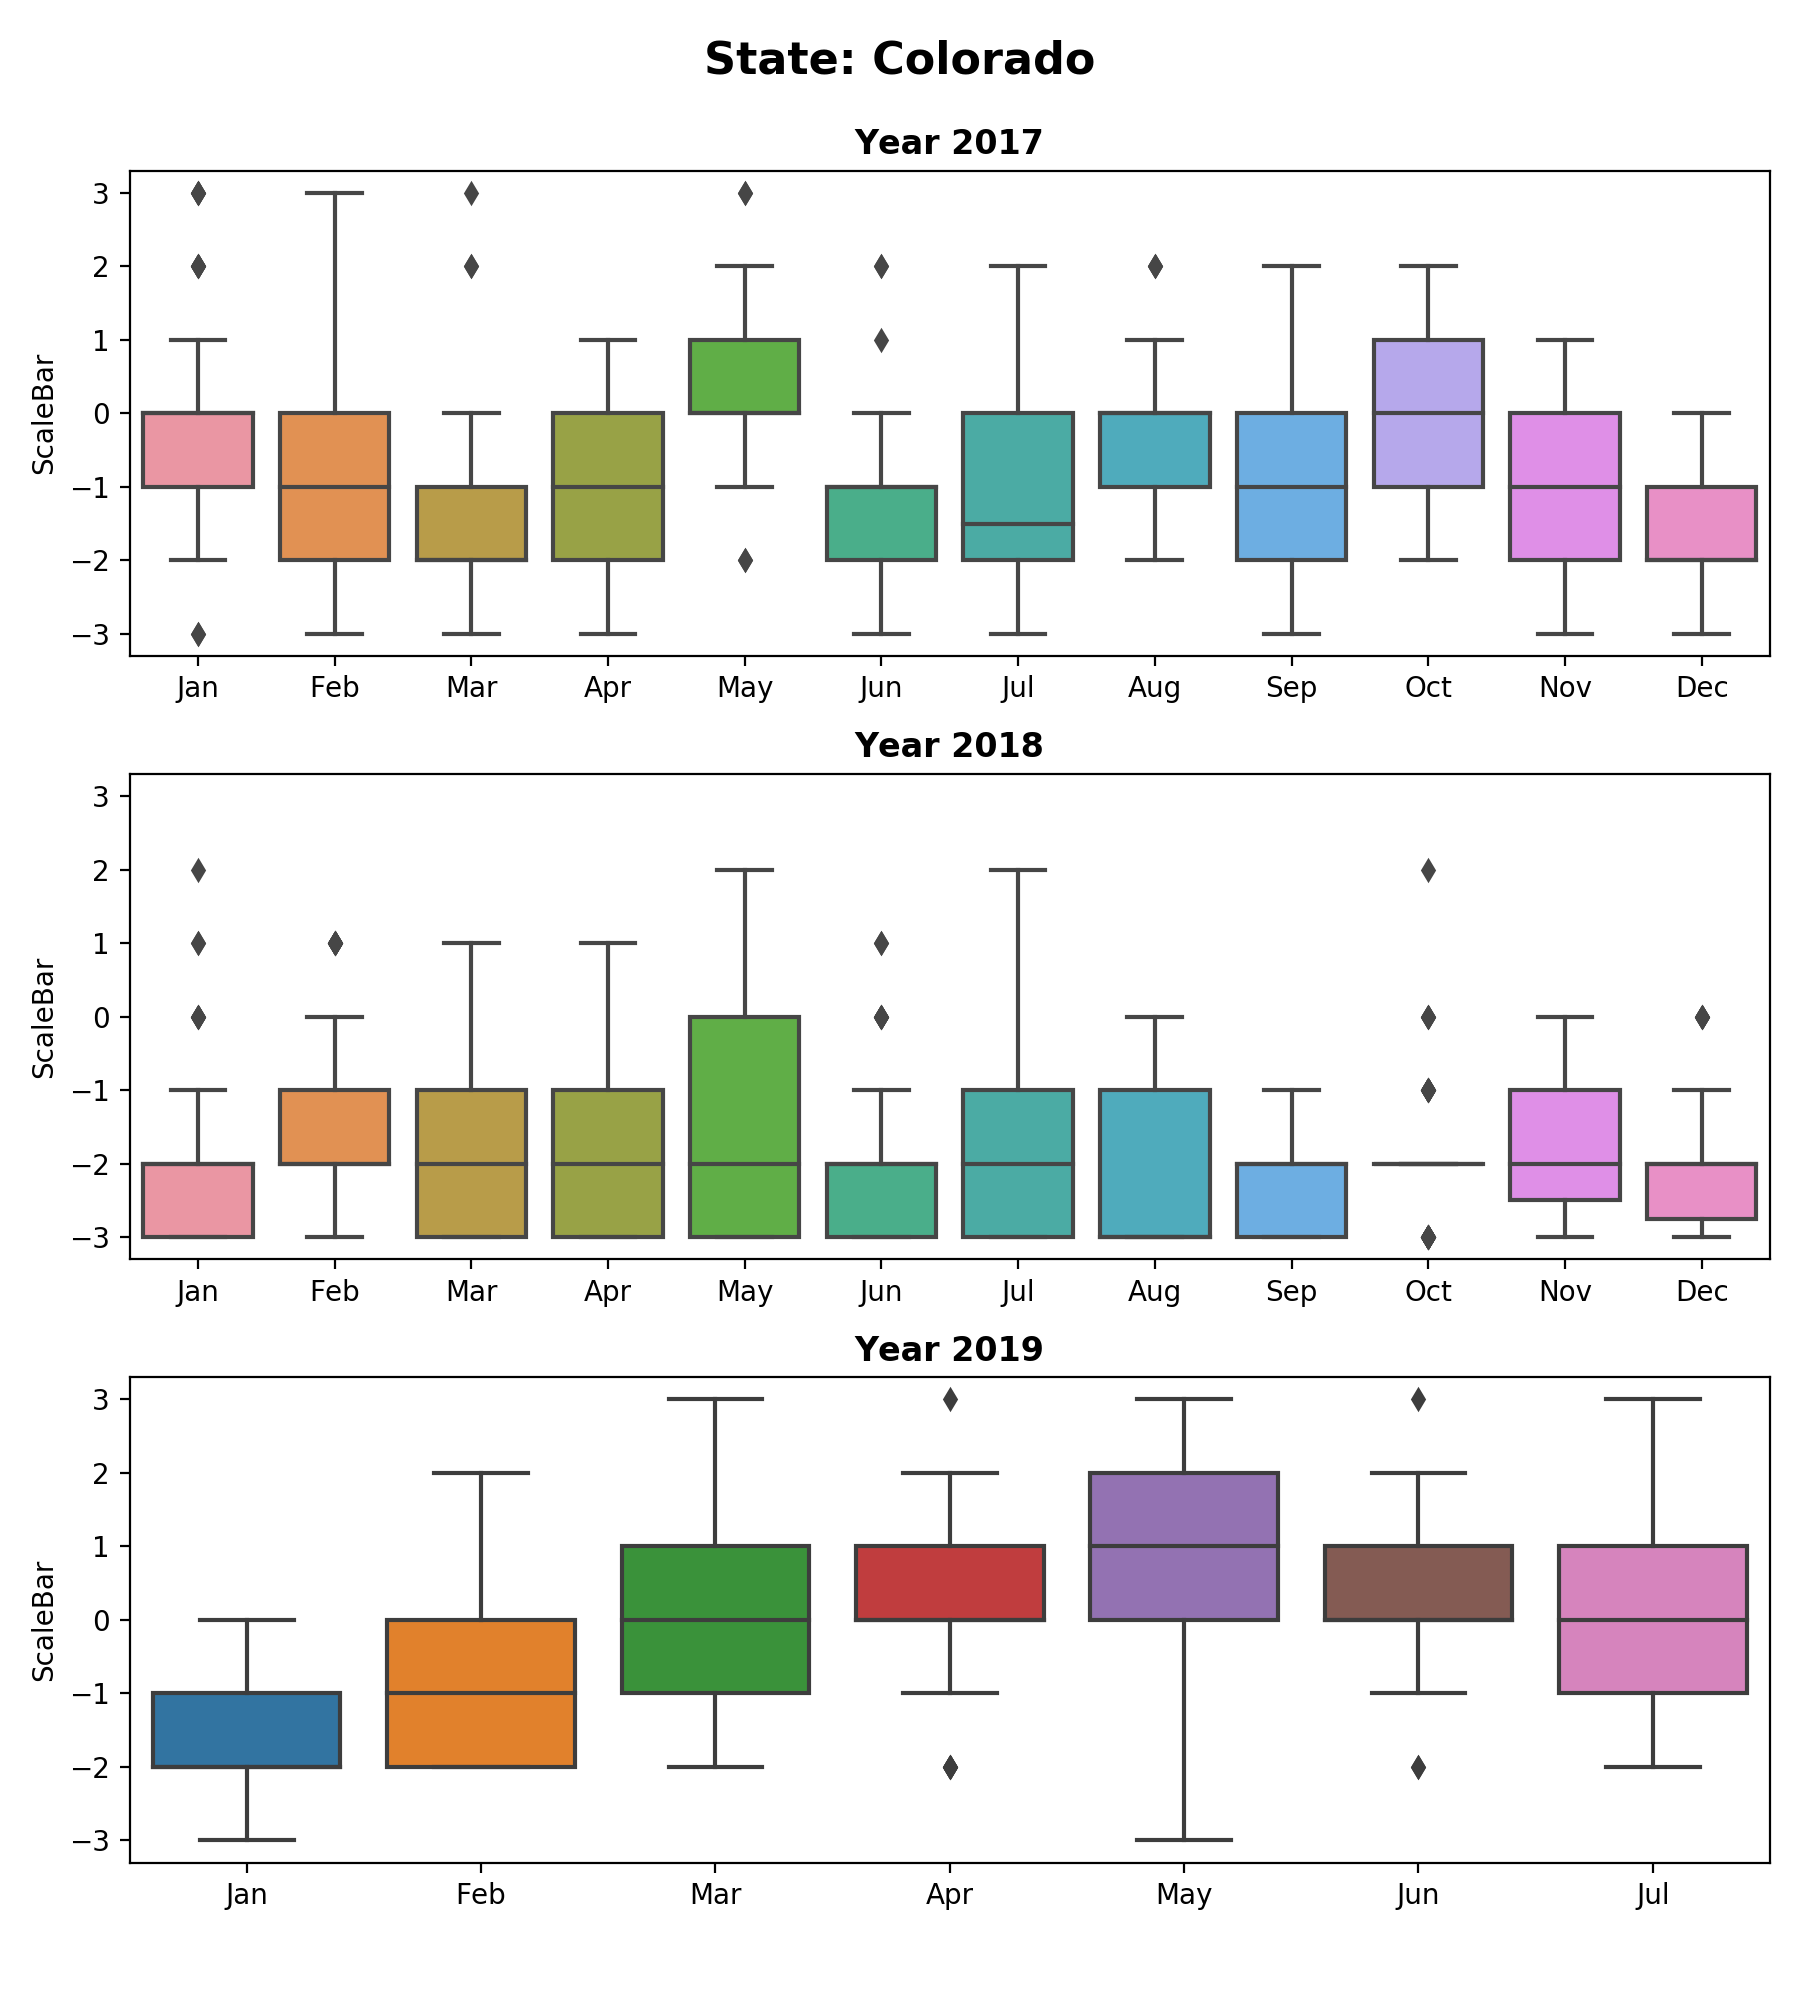

In [13]:
f, axes = plt.subplots(3, 1, sharey=True, sharex=False, figsize=(9, 10))

ax1 = sns.boxplot(x="month_name", y="ScaleBar", data=t_df_1, ax=axes[0])
ax2 = sns.boxplot(x="month_name", y="ScaleBar", data=t_df_2, ax=axes[1])
ax3 = sns.boxplot(x="month_name", y="ScaleBar", data=t_df_3, ax=axes[2])

ax1.set_title('Year 2017', fontsize=12, weight='bold')
ax2.set_title('Year 2018', fontsize=12, weight='bold')
ax3.set_title('Year 2019', fontsize=12, weight='bold')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

plt.suptitle('State: Colorado', fontsize=16, weight='bold')

f.tight_layout(rect=[0, 0.03, 1, 0.95])

## Monthly County Average ScaleBar for Year `2018` in State `Colorado`

**Organize the data**

In [14]:
t_df_2_1 = t_df_2[['County', 'month', 'ScaleBar']].groupby(['County', 'month']).agg({'ScaleBar': np.mean})
t_df_2_1 = t_df_2_1.reset_index().pivot(index='County', columns='month', values='ScaleBar')

**Generate the county heatmap**

<IPython.core.display.Javascript object>


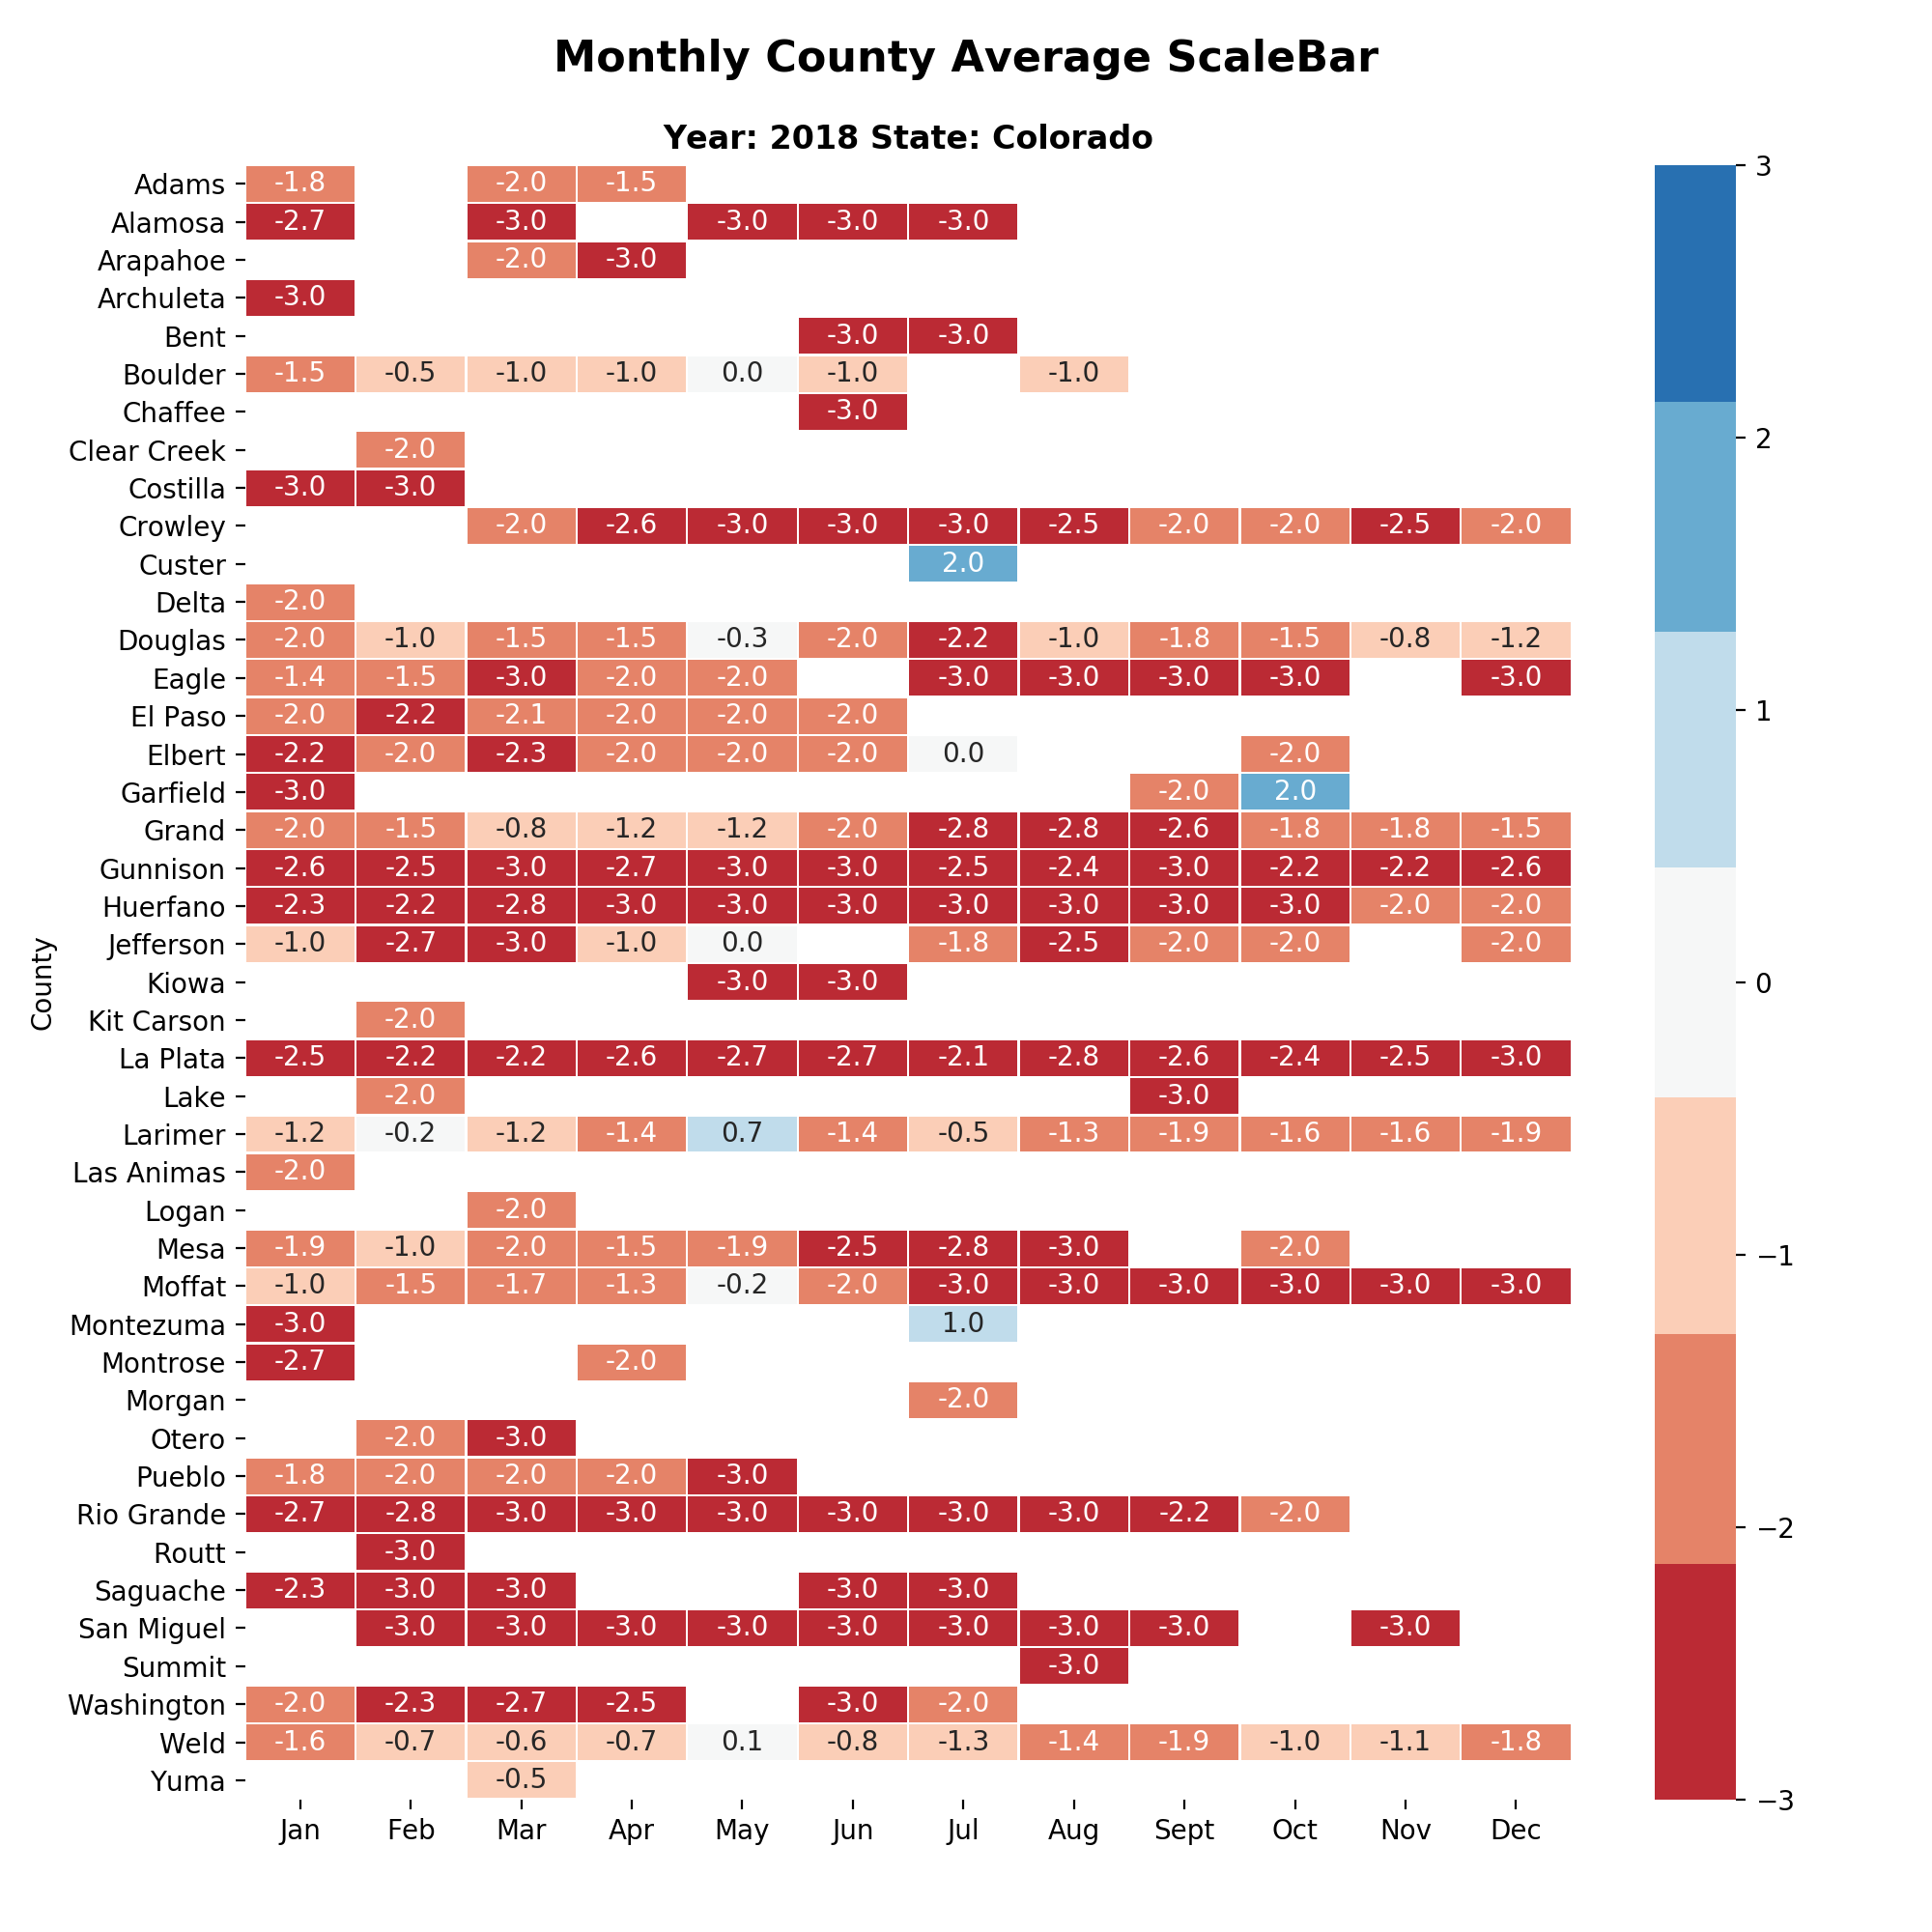

In [15]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(t_df_2_1, annot=True, linewidths=.5, fmt=".1f", cmap = sns.color_palette("RdBu", 7),
            center = 0.0, vmin=-3.0, vmax=3.0, ax=ax)

ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
ax.set_xlabel('')
ax.set_title('Year: 2018 State: Colorado', fontsize=12, weight='bold')
f.suptitle('Monthly County Average ScaleBar', fontsize=16, weight='bold')
f.tight_layout(rect=[0, 0.03, 1, 0.95])

## Wettest and Driest Counties in USA

**Select Years 2017, 2018, and 2019**

In [13]:
paried_df_2 = paried_df[paried_df.year > 2016]
paried_df_2.year.unique()

array([2017, 2018, 2019])

**Generate metrics and organize the data**

In [14]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

grouped = paried_df_2.groupby(['year', 'StateCode', 'County', 'month'])['ScaleBar'].agg( 
                                                                                         {
                                                                                             'mean': np.mean, 
                                                                                             'median': np.median, 
                                                                                             'min': np.min, 
                                                                                             'max': np.max, 
                                                                                             'upper': percentile(75), 
                                                                                             'lower': percentile(25), 
                                                                                             'count': 'count'
                                                                                         } 
                                                                                        )

In [15]:
grouped_2 = grouped.unstack('month')
grouped_2.columns = grouped_2.columns.swaplevel(0, 1)
grouped_2.sort_index(axis=1, level=0, inplace=True)
grouped_2.columns.names = ['month', 'metrics']
grouped_2.head()

month                      1                                       2        \
metrics                count lower  max mean median  min upper count lower   
year StateCode County                                                        
2017 1         Baldwin NaN   NaN   NaN  NaN  NaN    NaN  NaN   NaN   NaN     
               Butler   2.0   1.25  2.0  1.5  1.5    1.0  1.75 NaN   NaN     
               Cullman NaN   NaN   NaN  NaN  NaN    NaN  NaN   NaN   NaN     
               Houston  1.0   2.00  2.0  2.0  2.0    2.0  2.00 NaN   NaN     
               Jackson  2.0   1.50  3.0  2.0  2.0    1.0  2.50 NaN   NaN     

month                       ...     11               12                  \
metrics                max  ... median  min upper count lower  max mean   
year StateCode County       ...                                           
2017 1         Baldwin NaN  ... -2.0   -2.0 -2.0  NaN   NaN   NaN  NaN    
               Butler  NaN  ... NaN    NaN  NaN   NaN   NaN   NaN  NaN    
               Cullman NaN  ... NaN    NaN  NaN   NaN   NaN   NaN  NaN    
               Houston NaN  ... NaN    NaN  NaN   NaN   NaN   NaN  NaN    
               Jackson NaN  ... -2.0   -2.0 -2.0   3.0  -2.0  -2.0 -2.0   

month                                     
metrics                median  min upper  
year StateCode County                     
2017 1         Baldwin NaN    NaN  NaN    
               Butler  NaN    NaN  NaN    
               Cullman NaN    NaN  NaN    
               Houston NaN    NaN  NaN    
               Jackson -2.0   -2.0 -2.0   

[5 rows x 84 columns]

In [16]:
from itertools import groupby

def get_counts(x):
    a = x.values
    dry = np.where(a < -2.0, 1, 0)
    wet = np.where(a > 2.0, 1, 0)
    
    max_consq_dry = 0
    for key, value in groupby(dry):
        check_val = len(list(value))
        if (key == 1) and (max_consq_dry < check_val):
            max_consq_dry = check_val
            
    max_consq_wet = 0
    for key, value in groupby(wet):
        check_val = len(list(value))
        if (key == 1) and (max_consq_wet < check_val):
            max_consq_wet = check_val
    
    max_dry = 0
    u, c = np.unique(dry, return_counts=True)
    if(len(np.where(u==1)[0]) > 0):
        max_dry = c[np.where(u==1)[0][0]]
        
    max_wet = 0
    u, c = np.unique(wet, return_counts=True)
    if(len(np.where(u==1)[0]) > 0):
        max_wet = c[np.where(u==1)[0][0]]
        
    return max_dry, max_consq_dry, max_wet, max_consq_wet

In [17]:
grouped_2[['dry_months', 'max_cons_dry_months', 'wet_months', 'max_cons_wet_months']] = grouped_2.xs(
    'mean', level='metrics', axis=1).apply(get_counts, axis=1, result_type="expand")

grouped_2.head()

month                      1                                       2        \
metrics                count lower  max mean median  min upper count lower   
year StateCode County                                                        
2017 1         Baldwin NaN   NaN   NaN  NaN  NaN    NaN  NaN   NaN   NaN     
               Butler   2.0   1.25  2.0  1.5  1.5    1.0  1.75 NaN   NaN     
               Cullman NaN   NaN   NaN  NaN  NaN    NaN  NaN   NaN   NaN     
               Houston  1.0   2.00  2.0  2.0  2.0    2.0  2.00 NaN   NaN     
               Jackson  2.0   1.50  3.0  2.0  2.0    1.0  2.50 NaN   NaN     

month                       ...    12                             dry_months  \
metrics                max  ... lower  max mean median  min upper              
year StateCode County       ...                                                
2017 1         Baldwin NaN  ... NaN   NaN  NaN  NaN    NaN  NaN    0           
               Butler  NaN  ... NaN   NaN  NaN  NaN    NaN  NaN    0           
               Cullman NaN  ... NaN   NaN  NaN  NaN    NaN  NaN    0           
               Houston NaN  ... NaN   NaN  NaN  NaN    NaN  NaN    0           
               Jackson NaN  ... -2.0  -2.0 -2.0 -2.0   -2.0 -2.0   0           

month                  max_cons_dry_months wet_months max_cons_wet_months  
metrics                                                                    
year StateCode County                                                      
2017 1         Baldwin  0                   0          0                   
               Butler   0                   0          0                   
               Cullman  0                   0          0                   
               Houston  0                   0          0                   
               Jackson  0                   1          1                   

[5 rows x 88 columns]

### Top 10 Wettest Counties in USA: `Years: 2017-2019`

<IPython.core.display.Javascript object>


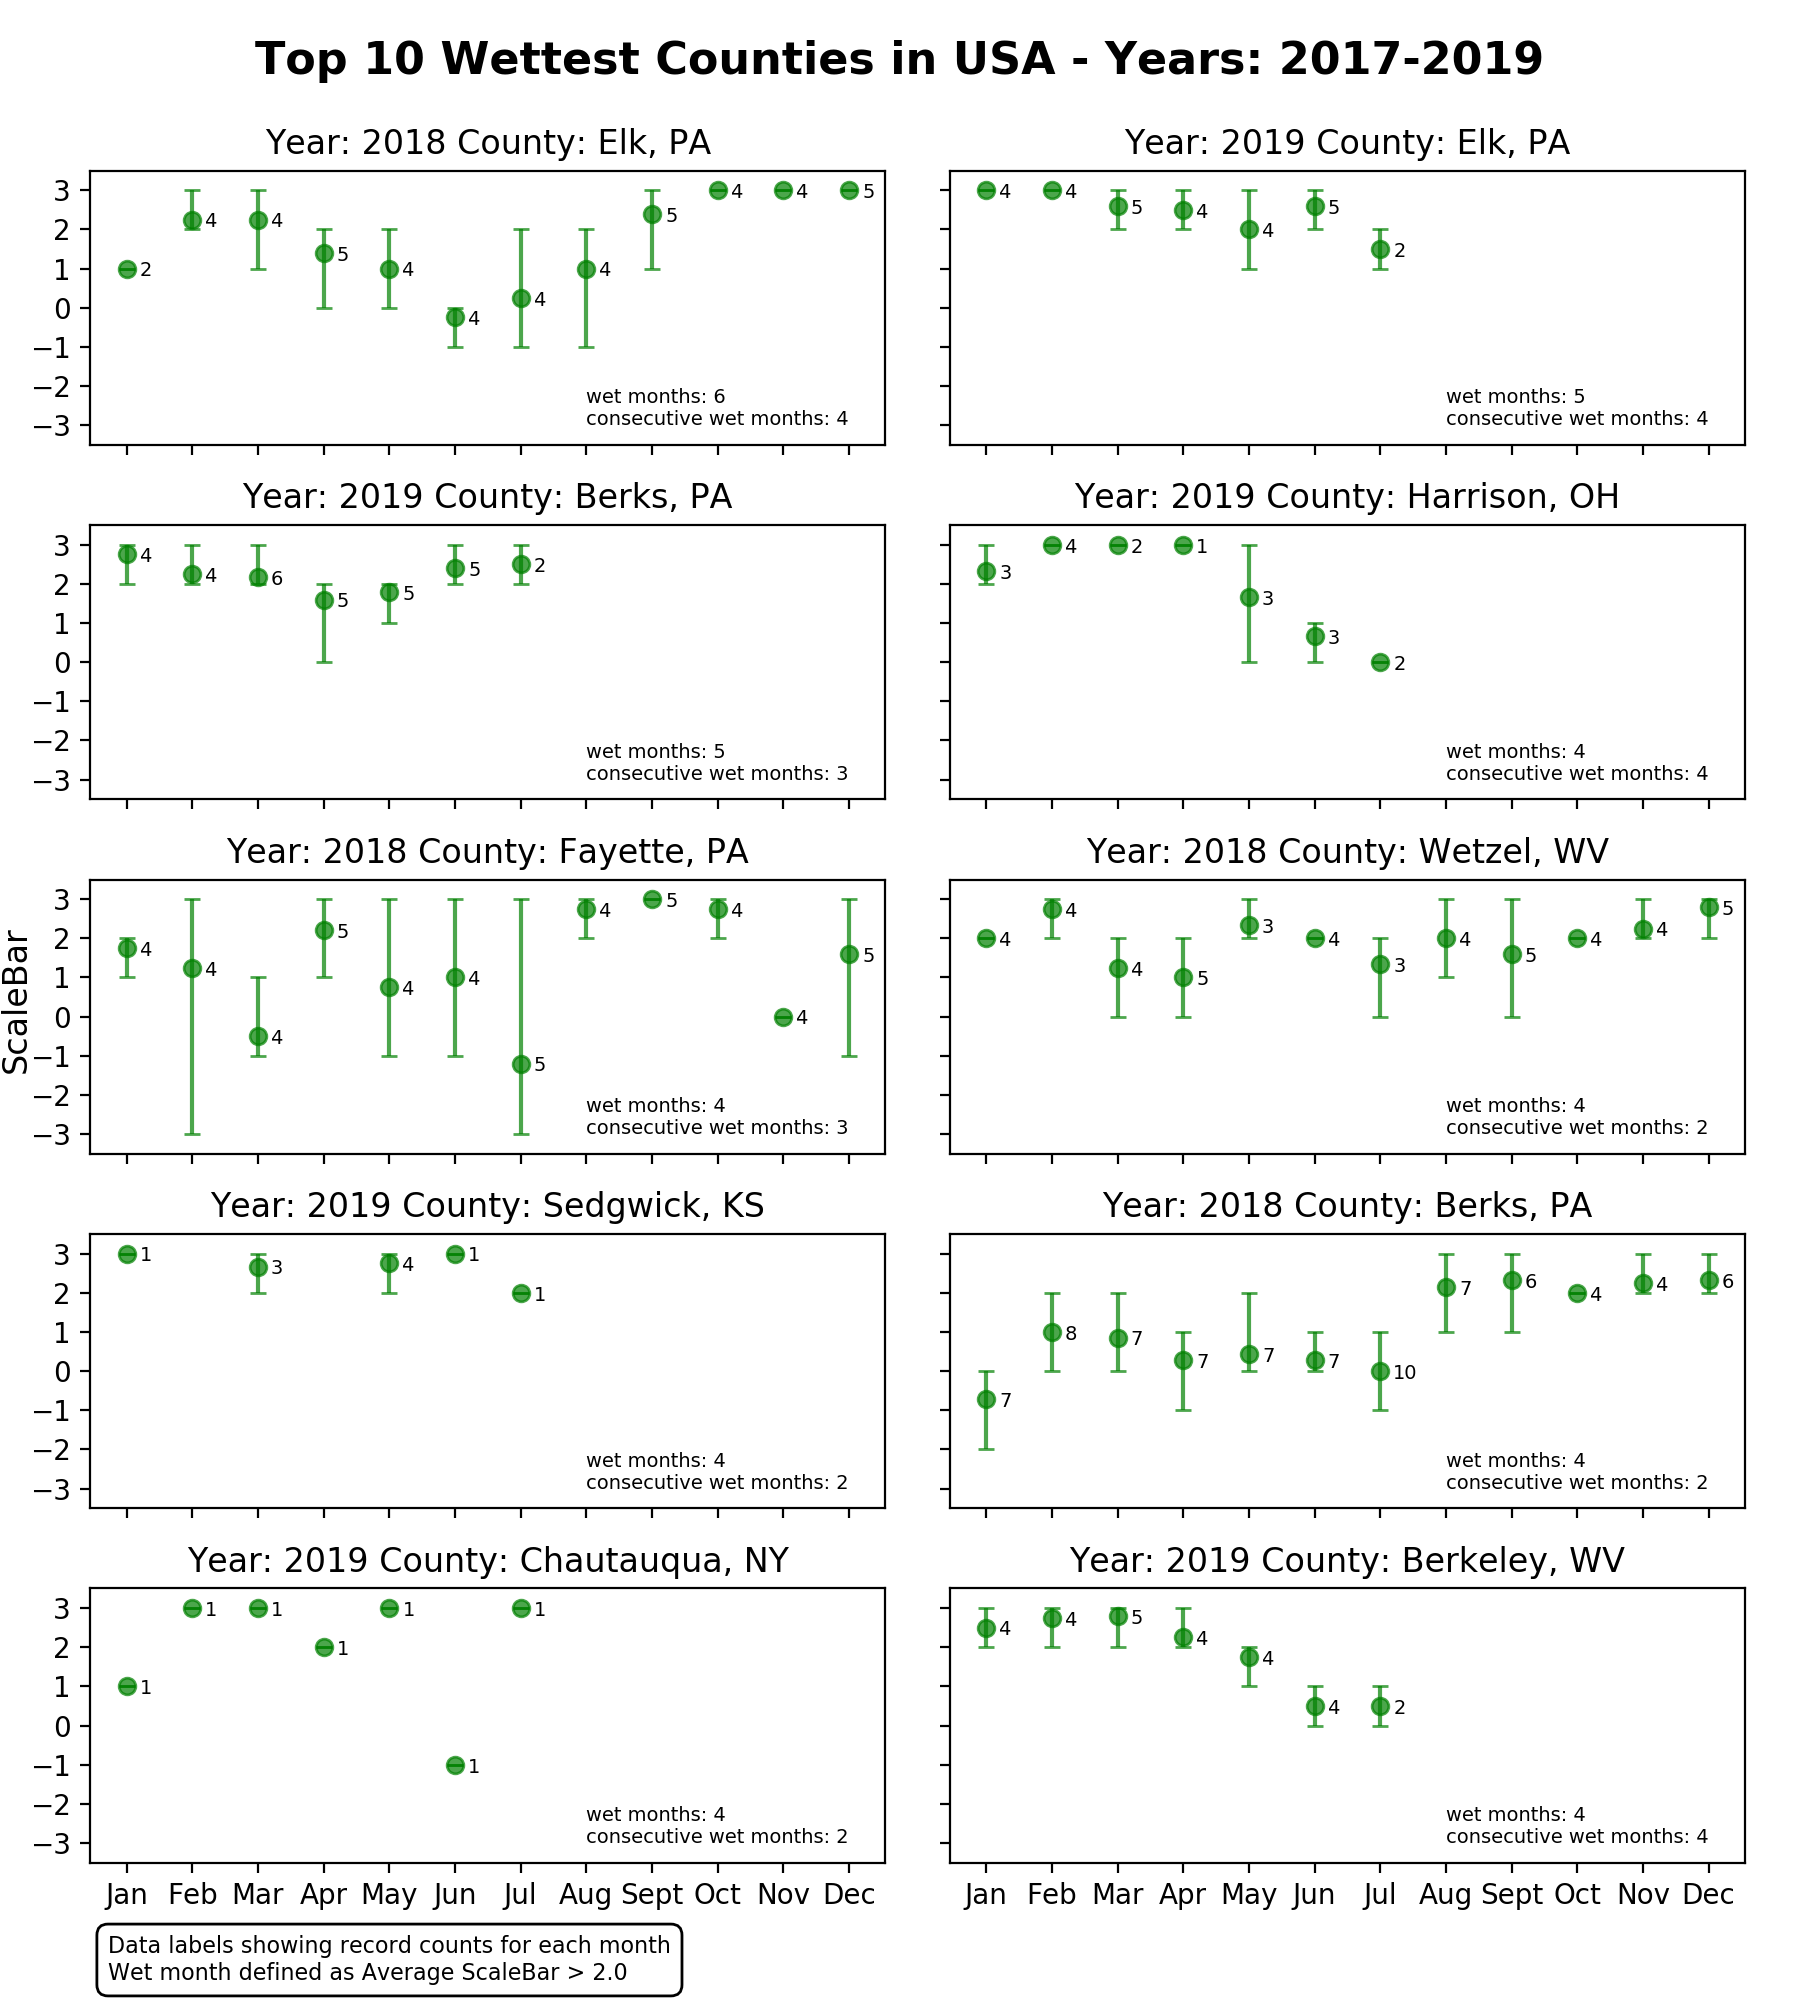

In [18]:
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 10))

n = 10
curr = grouped_2.sort_values(by=['wet_months'], ascending=False).head(n)
axs_list = np.ndarray.flatten(axs)

for i in range(10):
    index = curr.index[i]
    row = curr.iloc[i]
    upper = list(row[:, 'max'] - row[:, 'mean'])
    lower = list(row[:, 'mean'] - row[:, 'min'])
    err = np.vstack((lower, upper))
    
    ax = axs_list[i]
    ax.errorbar(row[:, 'mean'].index.values, row[:, 'mean'], err, 
             capsize=3, linestyle='None', marker='o', color='g', alpha=0.7)
    title = 'Year: {} County: {}, {}'.format(index[0], index[2], state_map[index[1]])
    ax.set_title(title)
    ax.set_ylim([-3.5, 3.5])
    
    for i, j, k in zip(row[:, 'mean'].index.values, row[:, 'mean'], row[:, 'count']):
        if not math.isnan(k):
            ax.annotate("{:d}".format(int(k)), xy=(i + 0.2, j - 0.2), fontsize=7)
    
    note = 'wet months: {:d}\nconsecutive wet months: {:d}'.format(
    int(row['wet_months'][0]), int(row['max_cons_wet_months'][0]))
    ax.annotate(note, xy=(8, -3), color='black', fontsize=7)
    
fig.text(0., 0.5, 'ScaleBar', va='center', rotation='vertical', fontsize=12)

plt.xticks(row[:, 'mean'].index.values, labels)
plt.yticks([-3, -2, -1, 0, 1, 2, 3])
plt.suptitle('Top 10 Wettest Counties in USA - Years: 2017-2019', fontsize=16, weight='bold')

footnote = 'Data labels showing record counts for each month\nWet month defined as Average ScaleBar > 2.0'
fig.text(0.06, 0.02, footnote, va='center', fontsize=8, color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round, pad=0.5'))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### Top 10 Driest Counties in USA: `Years: 2017-2019`

<IPython.core.display.Javascript object>


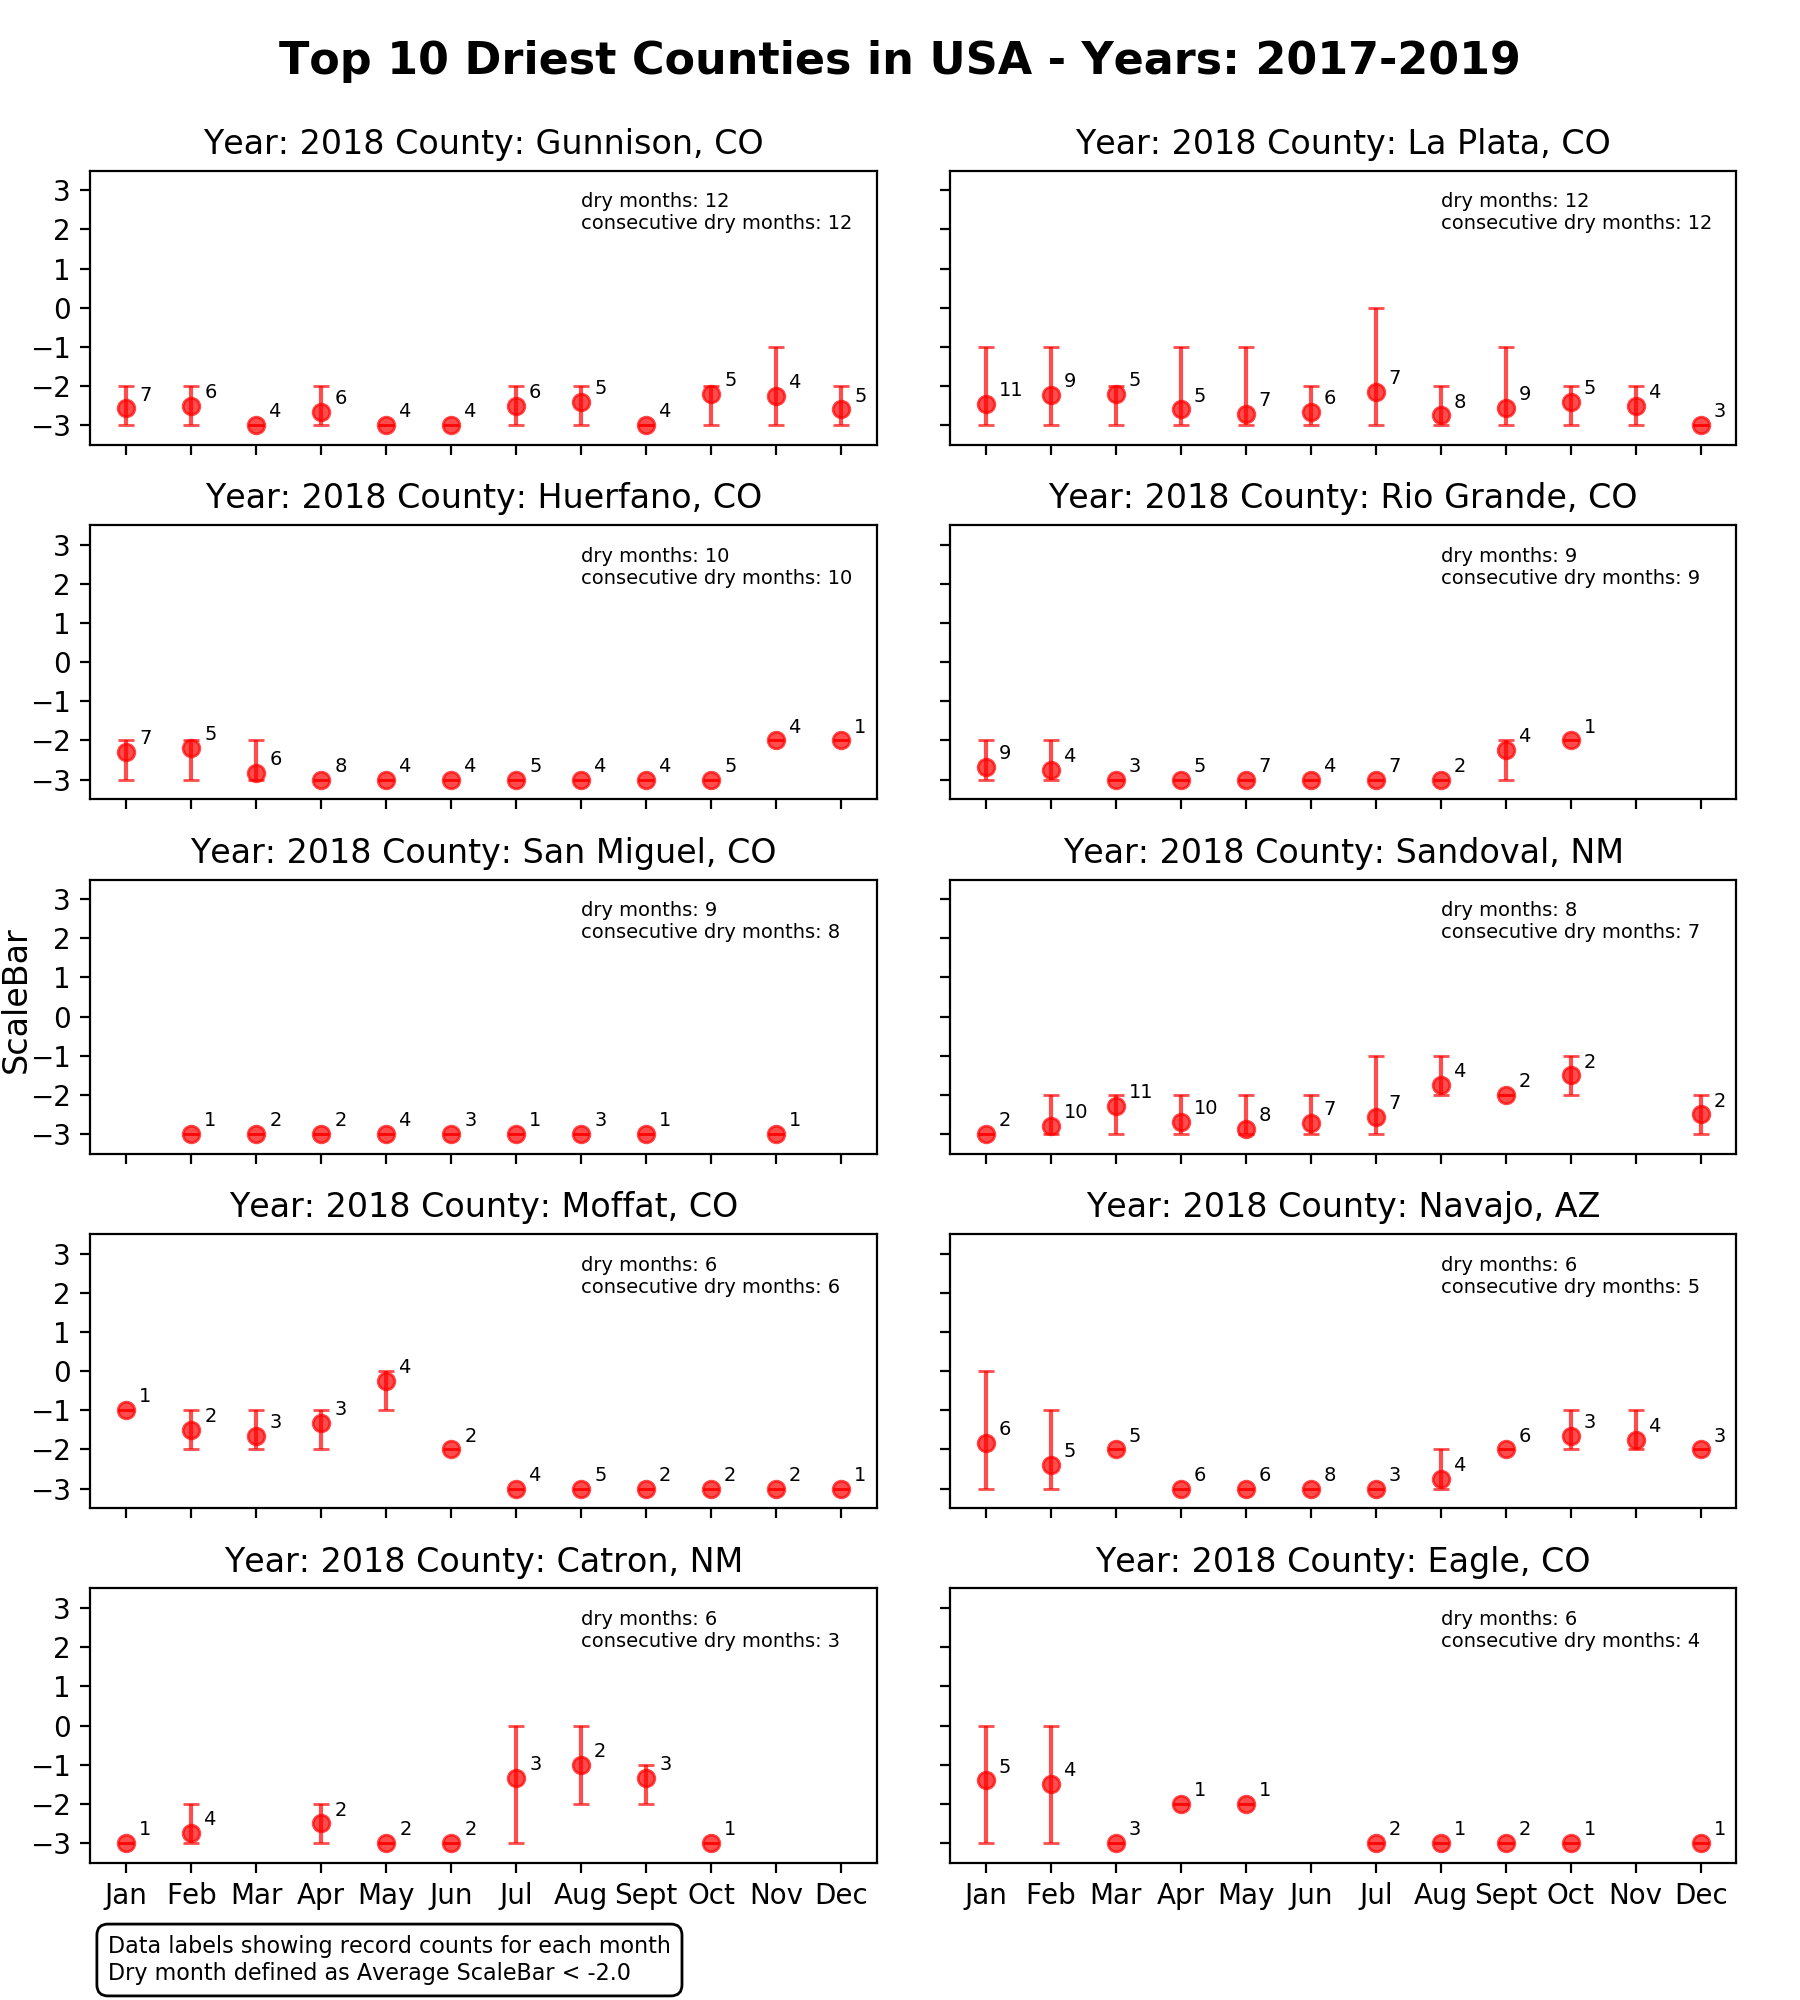

In [19]:
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(9, 10))

n = 10
curr = grouped_2.sort_values(by=['dry_months'], ascending=False).head(n)
axs_list = np.ndarray.flatten(axs)

for i in range(10):
    index = curr.index[i]
    row = curr.iloc[i]
    upper = list(row[:, 'max'] - row[:, 'mean'])
    lower = list(row[:, 'mean'] - row[:, 'min'])
    err = np.vstack((lower, upper))
    
    ax = axs_list[i]
    ax.errorbar(row[:, 'mean'].index.values, row[:, 'mean'], err, 
             capsize=3, linestyle='None', marker='o', color='r', alpha=0.7)
    title = 'Year: {} County: {}, {}'.format(index[0], index[2], state_map[index[1]])
    ax.set_title(title)
    ax.set_ylim([-3.5, 3.5])
    
    for i, j, k in zip(row[:, 'mean'].index.values, row[:, 'mean'], row[:, 'count']):
        if not math.isnan(k):
            ax.annotate("{:d}".format(int(k)), xy=(i + 0.2, j + 0.2), fontsize=7)
    
    note = 'dry months: {:d}\nconsecutive dry months: {:d}'.format(
    int(row['dry_months'][0]), int(row['max_cons_dry_months'][0]))
    ax.annotate(note, xy=(8, 2), color='black', fontsize=7)
    
fig.text(0., 0.5, 'ScaleBar', va='center', rotation='vertical', fontsize=12)
    
plt.xticks(row[:, 'mean'].index.values, labels)
plt.yticks([-3, -2, -1, 0, 1, 2, 3])
plt.suptitle('Top 10 Driest Counties in USA - Years: 2017-2019', fontsize=16, weight='bold')

footnote = 'Data labels showing record counts for each month\nDry month defined as Average ScaleBar < -2.0'
fig.text(0.06, 0.02, footnote, va='center', fontsize=8, color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round, pad=0.5'))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## USA Map View - Year 2018

In [10]:
import plotly
import plotly.graph_objects as go
print(plotly.__version__)

4.1.0


In [11]:
curr_year = 2018
data_slider = []
for month in sorted(paried_df.month.unique()):
    t_df = paried_df.where((paried_df.year == curr_year) & (paried_df.month == month)).dropna()
    t_df_2 = t_df[['State', 'ScaleBar']].groupby(['State']).agg({'ScaleBar': np.mean})
    t_df_2.reset_index(inplace=True)
    t_df_2['text'] = t_df_2.apply(lambda x: str(x.State) + ': ' + str(round(x.ScaleBar, 1)), axis=1)
    
    data_one_month = dict(
                        type='choropleth',
                        locations=t_df_2['State'],
                        z=t_df_2['ScaleBar'].astype(float),
                        zmax = 3.0,
                        zmin = -3.0,
                        locationmode='USA-states',
                        colorscale=[[0, 'red'], [0.5, 'white'], [1, 'green']],
                        autocolorscale=False,
                        hoverinfo='text',
                        text=t_df_2['text'], # hover text
                        marker_line_color='black', # line markers between states
                        colorbar_title="ScaleBar"
                        )
    
    data_slider.append(data_one_month)

In [12]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

steps = []

for i in range(len(data_slider)):
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label=months[i]) # label to be displayed for each step (month)
    step['args'][1][i] = True
    steps.append(step)

sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

In [13]:
layout = dict(geo=dict(scope='usa', 
                       projection={'type': 'albers usa'}, 
                       showlakes=True, 
                       lakecolor='rgb(156, 195, 247)'), 
              sliders=sliders,
              title_text='2018 US Averages')

fig = dict(data=data_slider, layout=layout)

# Uncomment the below line for the interactive map
#plotly.offline.iplot(fig)

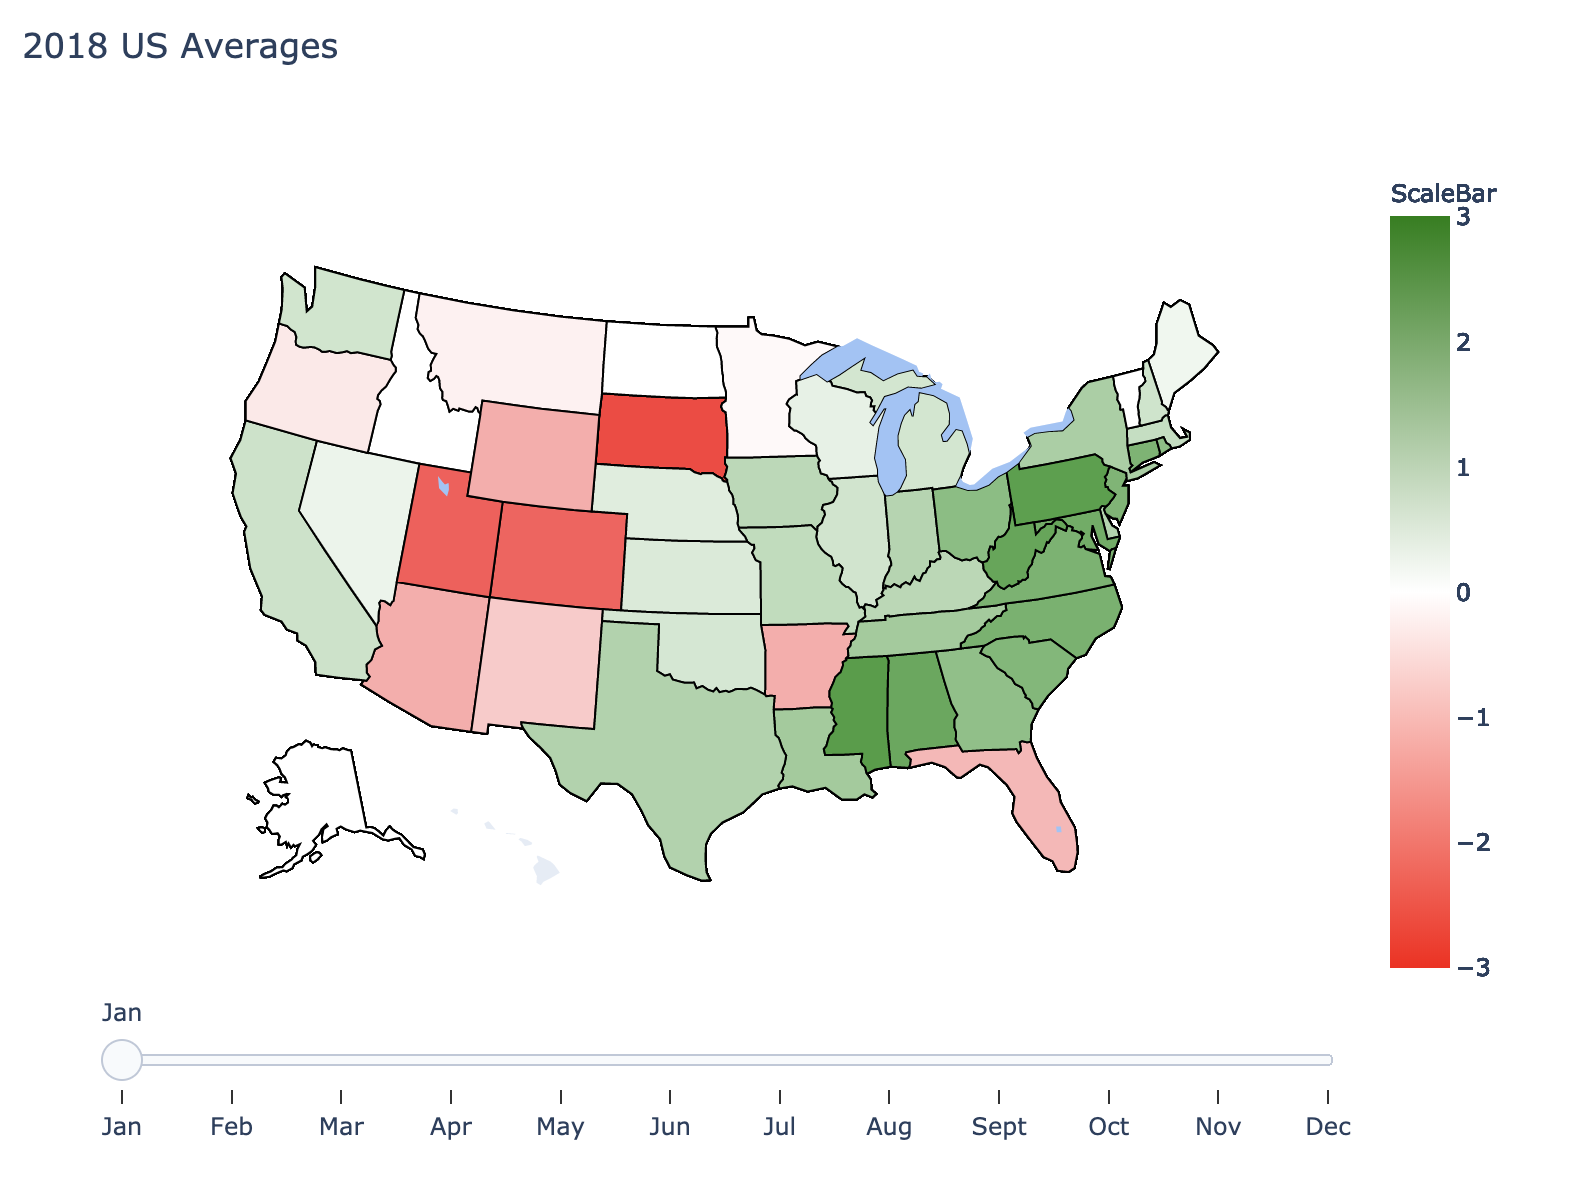

In [2]:
#SVG(filename='./images/usa2018.svg')
Image(filename='./images/usa2018.png')

## Florida County Map View - Year 2019

### Prepare monthly county level data

**You can change the values for Year, State, and Month for the plot**

- Valid years, 2017, 2018, and 2019
- Note that for 2019, we have data for months January to July
- The month number is a 0-based index, i.e. January = 0 and December = 11

In [11]:
curr_year = 2019
state_code = 'FL'
state_name = 'Florida'
current_month = 1 # February
current_month_name = 'February'

In [12]:
data_slider_fips = []
data_slider_values = []

t_df = paried_df.where((paried_df.year == curr_year) & (paried_df.State == state_code)).dropna()

for month in sorted(t_df.month.unique()):
    t_df_2 = t_df.where((t_df.month == month)).dropna()
        
    t_df_2 = t_df_2[['county_fips', 'County', 'ScaleBar']].groupby(
        ['county_fips', 'County']).agg({'ScaleBar': np.mean})
    t_df_2.reset_index(inplace=True)
    t_df_2.ScaleBar = t_df_2.ScaleBar.apply(lambda x: round(x, 2))
    t_df_2['text'] = t_df_2.apply(lambda x: ('County: {}\nState: {}\nScaleBar: {}').format(
        x.County, state_name, x.ScaleBar), axis=1)

    data_slider_fips.append(t_df_2['county_fips'].tolist())
    data_slider_values.append(t_df_2['ScaleBar'].astype(float).tolist())

### Plot county data

In [18]:
import plotly.figure_factory as ff

endpts = [-2.0, -1.0, 0, 1.0, 2.0]
colorscale = ["#FF0000","#FFC0CB","#FFFF00","#BFFF00",'#7CFC00', '#013220']

fig = ff.create_choropleth(fips=data_slider_fips[current_month], 
                           values=data_slider_values[current_month], 
                           colorscale=colorscale, 
                           binning_endpoints=endpts, 
                           county_outline={'color': 'rgb(255,255,255)', 'width': 1.0}, 
                           scope=[state_name], 
                           show_state_data=True, 
                           state_outline={'color': 'black', 'width': 1.0}, 
                           legend_title='Scale Bar')

fig.layout.title = '{} {} Average Scale Bar for Counties in {}'.format(current_month_name, curr_year, state_name)

# Uncomment the below line for the map
#fig.show()

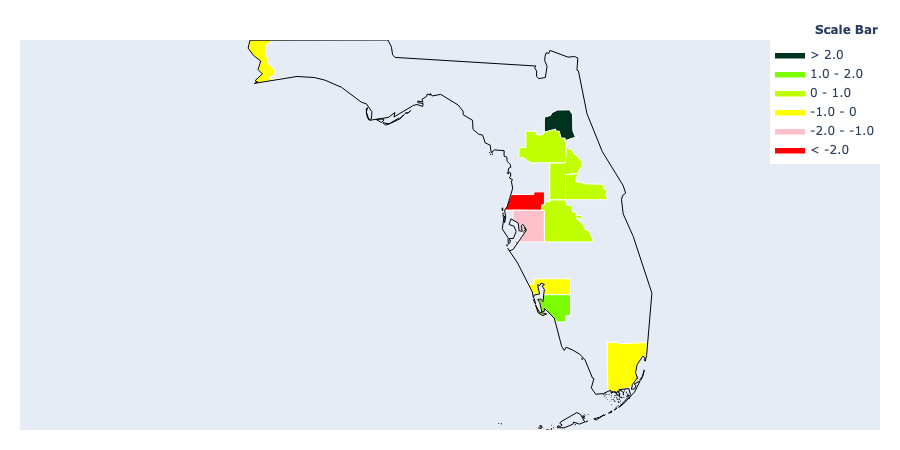

In [14]:
Image(filename='./images/fl_counties.png')

### Plot in a separate window

This is a workaround for an issue with plotly to see tooltips

Issue reported at: https://github.com/plotly/plotly.py/issues/1429

In [16]:
import plotly

plotly.offline.plot(fig, 
                    filename='choropleth_fl_counties.html', 
                    include_plotlyjs='https://cdn.plot.ly/plotly-1.42.3.min.js')

'choropleth_fl_counties.html'

In [17]:
!ls

choropleth_fl_counties.html  cocorahs-ai_book2.ipynb  images	 setup.ipynb
cocorahs-ai_book1.ipynb      cocorahs-ai_book3.ipynb  README.md


**Open the the HTML file saved in your folder**